# Import libraries

In [80]:
# Standard Libraries
import itertools
from datetime import datetime, timedelta
import re
import string
import warnings

# Suppressing Warnings
warnings.filterwarnings('ignore')

# Numerical and Data Manipulation Libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib import ticker

# Plotting options - light blue & light green colors
color = ['#a6cee3', '#b2df8a']
pd.set_option('display.max_colwidth', None)
plt.rcParams["figure.figsize"] = (9, 6)

# Statistical and Time Series Analysis Libraries
import statsmodels.api as sm
from statsmodels.api import tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Machine Learning Libraries
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

# Prophet for Time Series Forecasting
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

# XGBoost for Machine Learning
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Pandas Plotting
from pandas.plotting import lag_plot

# Utils 
# from ts_utils import load_and_clean_air_traffic, lag_plots, decompose_series, perform_adf_test, perform_kpss_test

In [2]:
east_cleaned_pd = pd.read_csv(
    '../data/east_england_data_revised_cleaned.csv',
    parse_dates=['count_date', 'timestamp']
)

# Ensure the correct data types for columns
east_cleaned_pd['Month'] = east_cleaned_pd['Month'].astype(int)
east_cleaned_pd['Day'] = east_cleaned_pd['Day'].astype(int)
east_cleaned_pd['hour'] = east_cleaned_pd['hour'].astype(int)
east_cleaned_pd['latitude'] = east_cleaned_pd['latitude'].astype(float)
east_cleaned_pd['longitude'] = east_cleaned_pd['longitude'].astype(float)


In [3]:
print(east_cleaned_pd.dtypes)

count_point_id                   int64
direction_of_travel             object
count_date              datetime64[ns]
hour                             int64
local_authority_name            object
road_type                       object
latitude                       float64
longitude                      float64
all_motor_vehicles             float64
Month                            int64
Day_of_Week                     object
Day                              int64
timestamp               datetime64[ns]
dtype: object


In [4]:
east_cleaned_pd.head()

,count_point_id,direction_of_travel,count_date,hour,local_authority_name,road_type,latitude,longitude,all_motor_vehicles,Month,Day_of_Week,Day,timestamp
0,6003,N,2000-03-31,7,Bedfordshire,Major,51.998107,-0.54127,4006.0,3,Friday,31,2000-03-31 07:00:00
1,6003,N,2000-03-31,8,Bedfordshire,Major,51.998107,-0.54127,4142.0,3,Friday,31,2000-03-31 08:00:00
2,6003,N,2000-03-31,9,Bedfordshire,Major,51.998107,-0.54127,3325.0,3,Friday,31,2000-03-31 09:00:00
3,6003,N,2000-03-31,10,Bedfordshire,Major,51.998107,-0.54127,3500.0,3,Friday,31,2000-03-31 10:00:00
4,6003,N,2000-03-31,11,Bedfordshire,Major,51.998107,-0.54127,3693.0,3,Friday,31,2000-03-31 11:00:00


In [5]:
east_cleaned_pd.shape

(550056, 13)

In [6]:
east_cleaned_pd.isnull().sum()

count_point_id          0
direction_of_travel     0
count_date              0
hour                    0
local_authority_name    0
road_type               0
latitude                0
longitude               0
all_motor_vehicles      2
Month                   0
Day_of_Week             0
Day                     0
timestamp               0
dtype: int64

In [7]:
east_cleaned_pd.duplicated().sum()

0

In [8]:
east_cleaned_pd.describe()

,count_point_id,count_date,hour,latitude,longitude,all_motor_vehicles,Month,Day,timestamp
count,550056.000000,550056,550056.000000,550056.000000,550056.000000,550054.000000,550056.000000,550056.000000,550056
mean,566127.527030,2011-11-12 20:24:48.441903616,12.499973,52.077520,0.366821,525.561992,6.624940,15.540709,2011-11-13 08:54:48.343733248
min,6003.000000,2000-03-17 00:00:00,3.000000,51.455053,-0.712785,0.000000,3.000000,1.000000,2000-03-17 07:00:00
25%,48454.000000,2006-06-07 00:00:00,9.000000,51.753123,-0.211865,45.000000,5.000000,8.000000,2006-06-07 13:00:00
50%,808769.500000,2011-05-18 00:00:00,12.000000,51.982011,0.345157,201.000000,6.000000,16.000000,2011-05-18 08:00:00
75%,941675.000000,2018-04-30 00:00:00,15.000000,52.410928,0.833575,648.000000,9.000000,23.000000,2018-04-30 09:00:00
max,999996.000000,2023-11-03 00:00:00,18.000000,58.453288,1.754553,8664.000000,11.000000,31.000000,2023-11-03 18:00:00
std,430179.200221,NaN,3.452071,0.390590,0.616583,805.842646,2.239346,8.406978,NaN


## Correlations

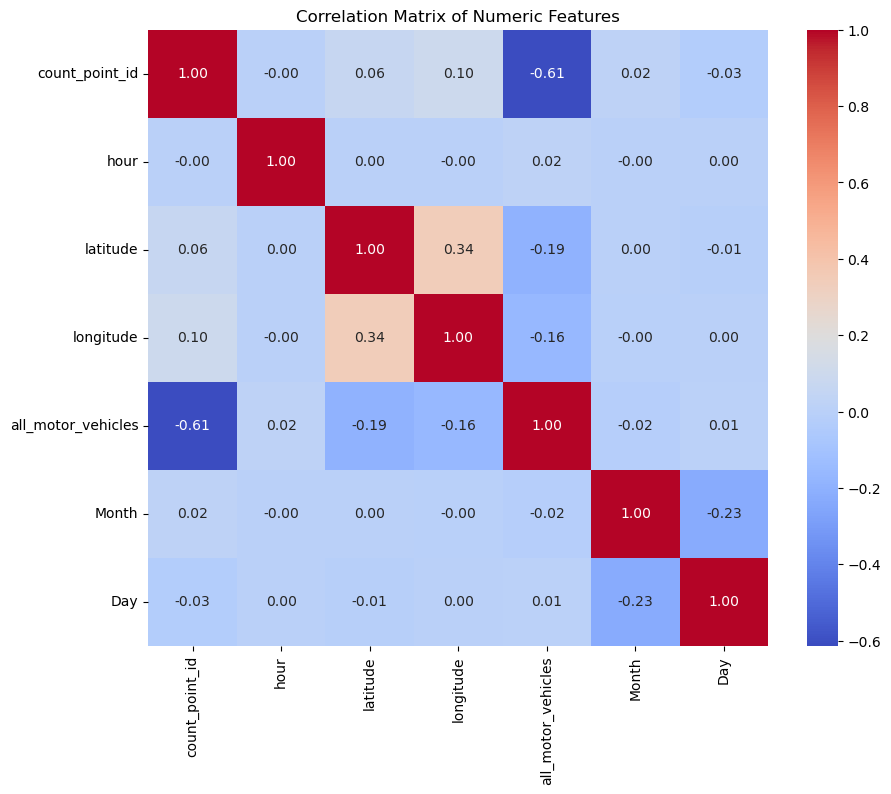

In [9]:
# Select only numeric columns
numeric_columns = east_cleaned_pd.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr = numeric_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

**Key Observations:**
- **Strong Negative Correlation**:

    - count_point_id and all_motor_vehicles: The strong negative correlation of -0.61 suggests that as count_point_id increases, the count of all_motor_vehicles decreases. This could be a point to show whether certain count points have fewer vehicles.
- **Positive Correlations:**
    -  latitude and longitude: There is a positive correlation of 0.34. This makes sense geographically, as locations' latitude and longitude within the same region are related.
- **Low or No Correlations:**
    - Many of the features like hour, Month, Day have very low correlations with other variables. For instance, hour shows no significant correlation with any other feature. This suggests that in this dataset, time (as measured by hour) may not play a role in relation to the other features.
- All Motor Vehicles (all_motor_vehicles):
    - Apart from the negative correlation with count_point_id (-0.61), it shows weak negative correlations with latitude (-0.19) and longitude (-0.16), which may be a slight geographic trends in motor vehicle counts. 
    - The correlation with hour (0.08) and Day_of_Week (0.07) is also weak, suggesting that these features may not be as important in predicting motor vehicle counts.


# Exploratory Data Analysis

In [10]:
def format_number(num):
    """
    Formats a large number by converting it into millions, rounding to one decimal place, 
    and removing any unnecessary trailing zeros and decimal points.
    
    Args:
        num (float): The number to be formatted.
    
    Returns:
        str: A string representing the number in millions, rounded to one decimal place.
    """
    return f"{num / 1_000_000:.1f} m".rstrip('0').rstrip('.')

In [11]:
east_cleaned_pd.columns

Index(['count_point_id', 'direction_of_travel', 'count_date', 'hour',
       'local_authority_name', 'road_type', 'latitude', 'longitude',
       'all_motor_vehicles', 'Month', 'Day_of_Week', 'Day', 'timestamp'],
      dtype='object')

### Aggreate the data by latitude and longitude

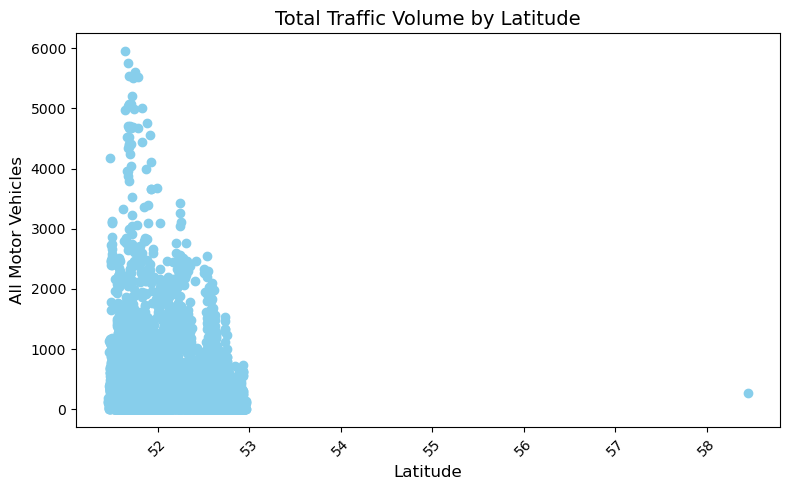

In [12]:
geo_traffic = east_cleaned_pd.groupby(['latitude', 'longitude']).agg({
    'all_motor_vehicles': 'mean'
}).reset_index()

### Sort the data by traffic volume
geo_traffic_sorted = geo_traffic.sort_values('all_motor_vehicles', ascending=False)

plt.figure(figsize=(8, 5))
plt.scatter(geo_traffic_sorted['latitude'], geo_traffic_sorted['all_motor_vehicles'], color='skyblue')
plt.title('Total Traffic Volume by Latitude', fontsize=14)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('All Motor Vehicles', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Note** A highest recorded traffic volumes (around 6000 vehicles) occur between latitudes 52 and 53(might likely represent busy regions with major roads or highways in the region).

In [13]:
east_cleaned_pd.columns

Index(['count_point_id', 'direction_of_travel', 'count_date', 'hour',
       'local_authority_name', 'road_type', 'latitude', 'longitude',
       'all_motor_vehicles', 'Month', 'Day_of_Week', 'Day', 'timestamp'],
      dtype='object')

In [14]:
east_cleaned_pd.shape

(550056, 13)

### Time factors and Road types

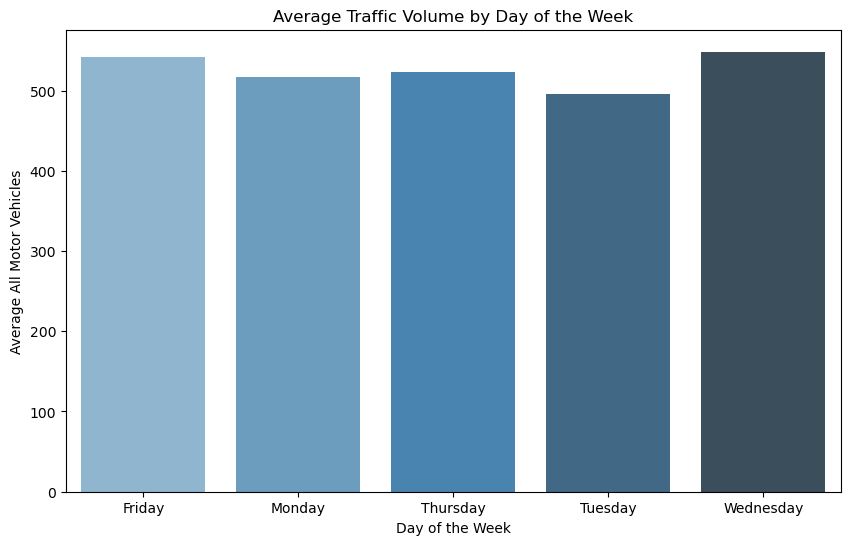

In [15]:
# Grouping data by Day of Week and calculating average traffic volume
traffic_by_day = east_cleaned_pd.groupby('Day_of_Week')['all_motor_vehicles'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Day_of_Week', y='all_motor_vehicles', data=traffic_by_day, palette='Blues_d')
plt.title('Average Traffic Volume by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average All Motor Vehicles')
plt.show()

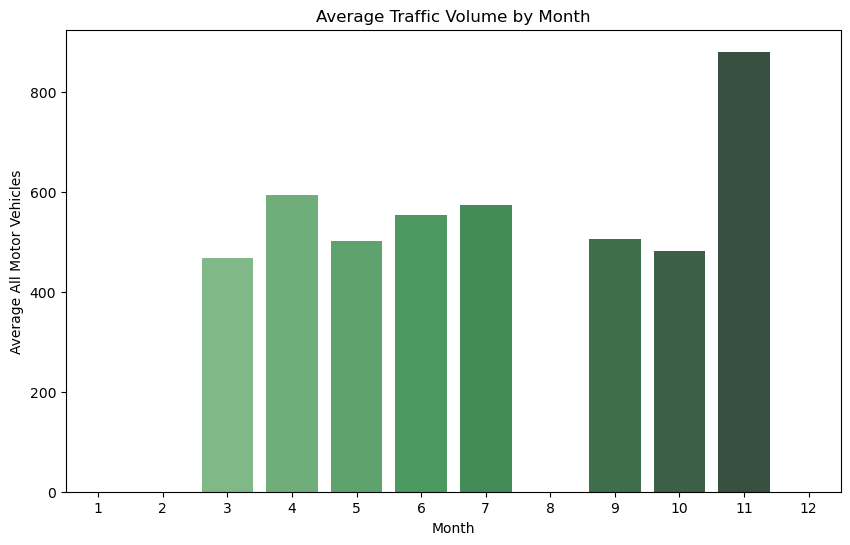

In [16]:
all_months = np.arange(1, 13) # list of all months (1 to 12)

# Grouping data by Month and calculating average traffic volume
avg_traffic_by_month = east_cleaned_pd.groupby('Month')['all_motor_vehicles'].mean().reindex(all_months, fill_value=0).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='all_motor_vehicles', data=avg_traffic_by_month, palette='Greens_d')
plt.title('Average Traffic Volume by Month')
plt.xlabel('Month')
plt.ylabel('Average All Motor Vehicles')
plt.show()

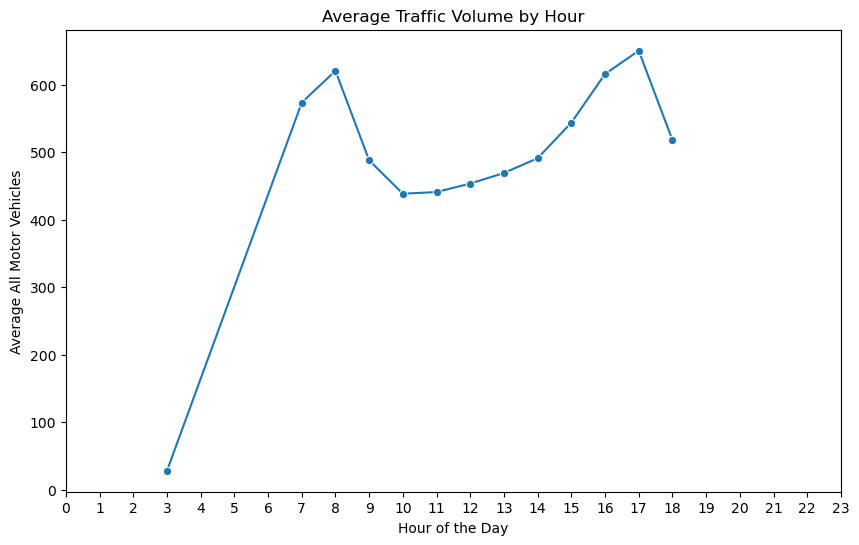

In [17]:
# Grouping data by hour and calculating average traffic volume
traffic_by_hour = east_cleaned_pd.groupby('hour')['all_motor_vehicles'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='all_motor_vehicles', data=traffic_by_hour, marker='o')
plt.title('Average Traffic Volume by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average All Motor Vehicles')
plt.xticks(range(0, 24))  # To ensure all hours are shown
plt.show()

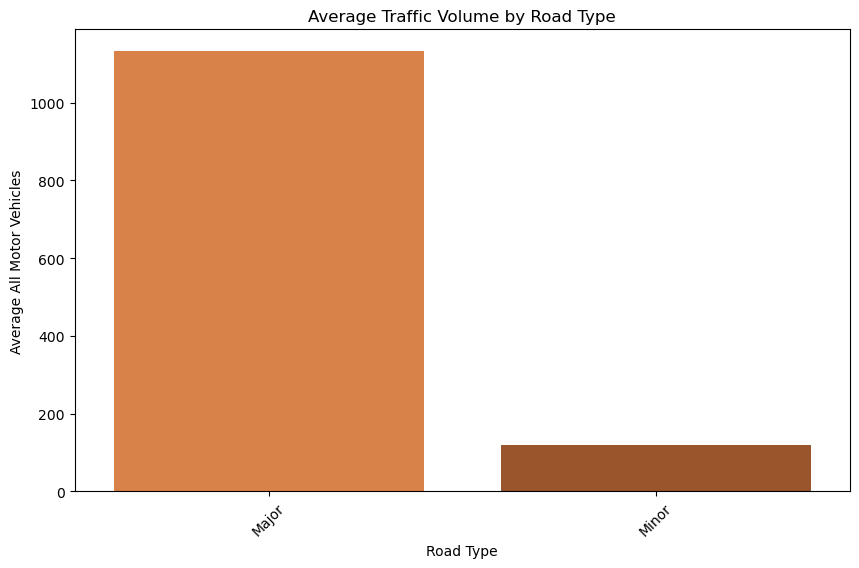

In [18]:

traffic_by_road_type = east_cleaned_pd.groupby('road_type')['all_motor_vehicles'].mean().reset_index()

# Plotting the average traffic volume by road type
plt.figure(figsize=(10, 6))
sns.barplot(x='road_type', y='all_motor_vehicles', data=traffic_by_road_type, palette='Oranges_d')
plt.title('Average Traffic Volume by Road Type')
plt.xlabel('Road Type')
plt.ylabel('Average All Motor Vehicles')
plt.xticks(rotation=45) 
plt.show()

**Note** There is a substantial disparity in traffic volume between major and minor roads. It could reflect both the road capacity and the types of vehicles using these roads. Major roads usually handle high-speed, long-distance traffic, while minor roads see local or neighborhood traffic.

### Group by month and day of the week to check for patterns

In [19]:
print(east_cleaned_pd[['timestamp', 'count_date', 'hour']].head())

            timestamp count_date  hour
0 2000-03-31 07:00:00 2000-03-31     7
1 2000-03-31 08:00:00 2000-03-31     8
2 2000-03-31 09:00:00 2000-03-31     9
3 2000-03-31 10:00:00 2000-03-31    10
4 2000-03-31 11:00:00 2000-03-31    11


In [20]:
# group by 'timestamp' - this is the hourly data 
hourly_grouped_data = east_cleaned_pd.groupby('timestamp').agg({"all_motor_vehicles": sum}).reset_index()
hourly_grouped_data.head()

,timestamp,all_motor_vehicles
0,2000-03-17 07:00:00,8187.0
1,2000-03-17 08:00:00,10022.0
2,2000-03-17 09:00:00,7651.0
3,2000-03-17 10:00:00,7203.0
4,2000-03-17 11:00:00,7458.0


In [21]:
hourly_grouped_data.shape

(29053, 2)

In [22]:
hourly_grouped_data.isna().sum()

timestamp             0
all_motor_vehicles    0
dtype: int64

In [23]:
print(hourly_grouped_data.index)

if not isinstance(hourly_grouped_data.index, pd.DatetimeIndex):
    hourly_grouped_data.set_index('timestamp', inplace=True)
print(hourly_grouped_data.index)

RangeIndex(start=0, stop=29053, step=1)
DatetimeIndex(['2000-03-17 07:00:00', '2000-03-17 08:00:00',
               '2000-03-17 09:00:00', '2000-03-17 10:00:00',
               '2000-03-17 11:00:00', '2000-03-17 12:00:00',
               '2000-03-17 13:00:00', '2000-03-17 14:00:00',
               '2000-03-17 15:00:00', '2000-03-17 16:00:00',
               ...
               '2023-11-03 09:00:00', '2023-11-03 10:00:00',
               '2023-11-03 11:00:00', '2023-11-03 12:00:00',
               '2023-11-03 13:00:00', '2023-11-03 14:00:00',
               '2023-11-03 15:00:00', '2023-11-03 16:00:00',
               '2023-11-03 17:00:00', '2023-11-03 18:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=29053, freq=None)


In [24]:
first_day = hourly_grouped_data.index.min()
last_day = hourly_grouped_data.index.max()

In [25]:
first_day

Timestamp('2000-03-17 07:00:00')

In [26]:
last_day

Timestamp('2023-11-03 18:00:00')

In [27]:
full_index = pd.date_range(start=first_day, end=last_day, freq="H")
full_index

DatetimeIndex(['2000-03-17 07:00:00', '2000-03-17 08:00:00',
               '2000-03-17 09:00:00', '2000-03-17 10:00:00',
               '2000-03-17 11:00:00', '2000-03-17 12:00:00',
               '2000-03-17 13:00:00', '2000-03-17 14:00:00',
               '2000-03-17 15:00:00', '2000-03-17 16:00:00',
               ...
               '2023-11-03 09:00:00', '2023-11-03 10:00:00',
               '2023-11-03 11:00:00', '2023-11-03 12:00:00',
               '2023-11-03 13:00:00', '2023-11-03 14:00:00',
               '2023-11-03 15:00:00', '2023-11-03 16:00:00',
               '2023-11-03 17:00:00', '2023-11-03 18:00:00'],
              dtype='datetime64[ns]', length=207156, freq='H')

In [28]:
# calculate the difference between the full index and the hourly grouped data index
full_index.difference(hourly_grouped_data.index).shape

(178103,)

In [29]:
full_index.isnull().sum()

0

**Notes**
- There are 78,103 missing hourly timestamps in your hourly_grouped_data compared to the full range of hours in full_index (from first_day to last_day).
- There are significant gaps in the data, with the highest number of missing values occurring in the months of January and February.
- There are also missing values in the 'all_motor_vehicles' column, which is a count of all motor vehicles in the dataset.

**Questions**
- What is the highest number of missing values in the 'all_motor_vehicles' column?

**Possible Causes**
- Data collection gaps: There could be gaps in how the data was collected (e.g., certain hours or days were not recorded).
- Filtered data: the dataset might be filtered for specific conditions or events, which could explain the missing timestamps.

In [30]:
# Reindexing the DataFrame to fill in missing values in hourly_grouped_data to ensure continuous hourly index from start to end
hourly_grouped_data_cleaned = hourly_grouped_data.reindex(full_index)

In [31]:
hourly_grouped_data_cleaned.columns

Index(['all_motor_vehicles'], dtype='object')

In [32]:
hourly_grouped_data_cleaned.shape

(207156, 1)

In [33]:
hourly_grouped_data_cleaned = hourly_grouped_data_cleaned.reset_index()
hourly_grouped_data_cleaned.rename(columns={'index': 'timestamp'}, inplace=True)
print(hourly_grouped_data_cleaned.head())

            timestamp  all_motor_vehicles
0 2000-03-17 07:00:00              8187.0
1 2000-03-17 08:00:00             10022.0
2 2000-03-17 09:00:00              7651.0
3 2000-03-17 10:00:00              7203.0
4 2000-03-17 11:00:00              7458.0


In [34]:
hourly_grouped_data_cleaned.shape

(207156, 2)

In [35]:
hourly_grouped_data_cleaned.head()

,timestamp,all_motor_vehicles
0,2000-03-17 07:00:00,8187.0
1,2000-03-17 08:00:00,10022.0
2,2000-03-17 09:00:00,7651.0
3,2000-03-17 10:00:00,7203.0
4,2000-03-17 11:00:00,7458.0


In [36]:
hourly_grouped_data_cleaned.isna().sum()

timestamp                  0
all_motor_vehicles    178103
dtype: int64

In [37]:
# hourly_grouped_data_cleaned.set_index('timestamp', inplace=True)

In [38]:
hourly_grouped_data_cleaned['all_motor_vehicles'].fillna(method='ffill', inplace=True)

In [39]:
hourly_grouped_data_cleaned.isna().sum()

timestamp             0
all_motor_vehicles    0
dtype: int64

In [40]:
# hourly_grouped_data_cleaned.set_index('timestamp', inplace=True)

In [41]:
hourly_grouped_data_cleaned[hourly_grouped_data_cleaned['all_motor_vehicles'] > 0].shape

(207156, 2)

In [42]:
hourly_average_zeros = hourly_grouped_data_cleaned[hourly_grouped_data_cleaned['all_motor_vehicles'] == 0].shape
print(hourly_average_zeros)

(0, 2)


In [43]:
# Ensure the 'timestamp' column is in datetime format
hourly_grouped_data_cleaned['timestamp'] = pd.to_datetime(hourly_grouped_data_cleaned['timestamp'])

# Set 'timestamp' as the index
hourly_grouped_data_cleaned.set_index('timestamp', inplace=True)

# Now, resample the data to monthly and sum the values
monthly_average_traffic = hourly_grouped_data_cleaned.resample('MS').sum().reset_index()

# Display the first few rows of the resampled DataFrame
print(monthly_average_traffic.head(10))


   timestamp  all_motor_vehicles
0 2000-03-01           4079983.0
1 2000-04-01          11856901.0
2 2000-05-01           9222997.0
3 2000-06-01           8759275.0
4 2000-07-01          10122191.0
5 2000-08-01           9359520.0
6 2000-09-01           8239066.0
7 2000-10-01           9456167.0
8 2000-11-01           6891120.0
9 2000-12-01           7120824.0


In [44]:
# monthly_average_traffic = hourly_grouped_data_cleaned.resample('MS').sum().reset_index()

# # Display the resampled DataFrame
# print(monthly_average_traffic.head(10))

In [45]:
monthly_average_traffic.shape

(285, 2)

In [46]:
monthly_average_traffic.describe()

,timestamp,all_motor_vehicles
count,285,2.850000e+02
mean,2011-12-31 16:10:06.315789568,6.764725e+06
min,2000-03-01 00:00:00,6.696000e+03
25%,2006-02-01 00:00:00,3.758400e+06
50%,2012-01-01 00:00:00,6.659799e+06
75%,2017-12-01 00:00:00,8.878896e+06
max,2023-11-01 00:00:00,2.844014e+07
std,NaN,4.600634e+06


In [47]:
monthly_average_traffic.isna().sum()

timestamp             0
all_motor_vehicles    0
dtype: int64

In [48]:
numeric_description = monthly_average_traffic.describe(include=[np.number])
print(numeric_description)

       all_motor_vehicles
count        2.850000e+02
mean         6.764725e+06
std          4.600634e+06
min          6.696000e+03
25%          3.758400e+06
50%          6.659799e+06
75%          8.878896e+06
max          2.844014e+07


In [49]:
monthly_data = monthly_average_traffic.copy()

In [50]:
monthly_data.shape

(285, 2)

In [51]:
monthly_data.head()

,timestamp,all_motor_vehicles
0,2000-03-01,4079983.0
1,2000-04-01,11856901.0
2,2000-05-01,9222997.0
3,2000-06-01,8759275.0
4,2000-07-01,10122191.0


In [52]:
monthly_data.head()

,timestamp,all_motor_vehicles
0,2000-03-01,4079983.0
1,2000-04-01,11856901.0
2,2000-05-01,9222997.0
3,2000-06-01,8759275.0
4,2000-07-01,10122191.0


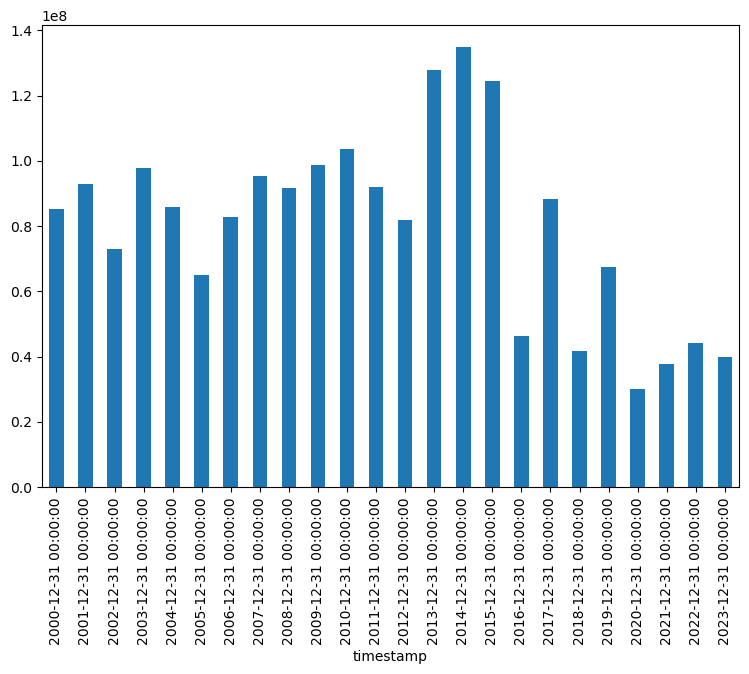

In [55]:
monthly_data.set_index('timestamp', inplace=True)
monthly_data_traffic_yearly = monthly_data.resample('Y').sum()
monthly_data_traffic_yearly['all_motor_vehicles'].plot(kind='bar')
plt.show()

**Interpretation**

- Traffic Growth until 2013-2014: The consistent increase in traffic up to 2014 might reflect growing vehicle usage, infrastructure development, or population increases during that period.

- Post-2014 Decline: The significant drop in traffic from 2015 onward could be due to various factors like changing transport policies, the rise of alternative transport modes, or global events affecting vehicle usage (e.g., oil price fluctuations, economic downturns, etc.).

- Impact of COVID-19 (2020-2021): The sharp decline in traffic in 2020 aligns with the global pandemic, where many countries experienced lockdowns and reduced movement, leading to lower traffic volumes. 

### Traffic Trends Analysis

In [90]:
def plot_rolling_mean_and_std(series: pd.Series, window: int) -> None:
    """
    This function plots the rolling mean and rolling standard deviation
    of a time series to help visually inspect stationarity.
    
    Args:
        series (pd.Series): Time series data (single column)
        window (int): Window size for rolling calculations (in time units)
        
    Returns: 
        None
    """
    # Get Rolling Mean and STD
    roll_mean = series.rolling(window=window).mean()
    roll_std = series.rolling(window=window).std()

    # Plot original series, rolling mean, and rolling standard deviation
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original', color='blue', alpha=0.5)
    plt.plot(roll_mean, label=f'Rolling Mean (window={window})', color='red')
    plt.plot(roll_std, label=f'Rolling STD (window={window})', color='green')
    
    # Adding titles and labels
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [81]:
# import plotly.graph_objects as go
# import pandas as pd

# def plot_rolling_mean_and_std(series: pd.Series, window: int) -> None:
#     """
#     This function plots the rolling mean and rolling standard deviation
#     of a time series to help visually inspect stationarity using Plotly.
    
#     Args:
#         series (pd.Series): Time series data (single column)
#         window (int): Window size for rolling calculations (in time units)
        
#     Returns: 
#         None
#     """
#     # Get Rolling Mean and STD
#     roll_mean = series.rolling(window=window).mean()
#     roll_std = series.rolling(window=window).std()

#     # Create a new Plotly figure
#     fig = go.Figure()

#     # Add original series line
#     fig.add_trace(go.Scatter(x=series.index, y=series,
#                              mode='lines', name='Original',
#                              line=dict(color='blue', width=2, dash='solid'),
#                              opacity=0.5))

#     # Add rolling mean line
#     fig.add_trace(go.Scatter(x=roll_mean.index, y=roll_mean,
#                              mode='lines', name=f'Rolling Mean (window={window})',
#                              line=dict(color='red', width=2)))

#     # Add rolling standard deviation line
#     fig.add_trace(go.Scatter(x=roll_std.index, y=roll_std,
#                              mode='lines', name=f'Rolling STD (window={window})',
#                              line=dict(color='green', width=2)))

#     # Update layout with titles, labels, and legend
#     fig.update_layout(title='Rolling Mean & Standard Deviation',
#                       xaxis_title='Date',
#                       yaxis_title='Values',
#                       legend_title='Legend',
#                       xaxis_tickformat='%Y-%m-%d')

#     # Show the plot
#     fig.show()


In [93]:
def plot_rolling_mean_and_std(dataframe: pd.DataFrame, window: int) -> None:
    """
    This function plots the dataframes
    rolling mean and rolling standard deviation.
    ---
    Args:
        dataframe (pd.DataFrame): Dataframe contains the timeseries
        window (int): window size
    Returns: None
    """
    df = dataframe.copy()
    # Get Things Rolling
    roll_mean = df.rolling(window=window).mean()
    roll_std = df.rolling(window=window).std()

    # Figure
    fig, ax = plt.subplots(figsize=(16, 9), facecolor='w')
    ax.plot(df, label='Original')
    ax.plot(roll_mean, label='Rolling Mean')
    ax.plot(roll_std,  label='Rolling STD')

    # Legend & Grid
    ax.legend(loc='upper right')
    plt.grid(linestyle=":", color='grey')
    plt.show()

In [58]:
monthly_data.head()

,all_motor_vehicles
timestamp,
2000-03-01,4079983.0
2000-04-01,11856901.0
2000-05-01,9222997.0
2000-06-01,8759275.0
2000-07-01,10122191.0


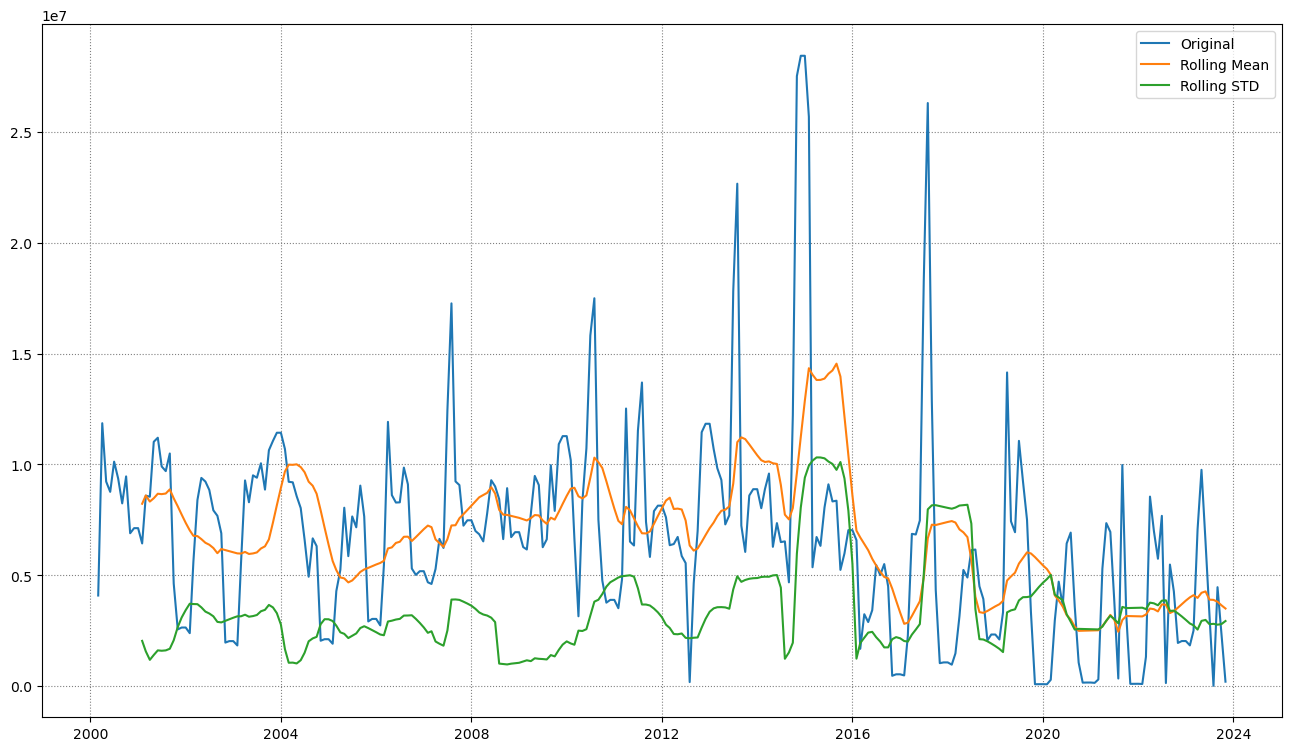

In [94]:

# Plot the rolling mean and standard deviation for a 12-month window 
plot_rolling_mean_and_std(monthly_data['all_motor_vehicles'], window=12) 

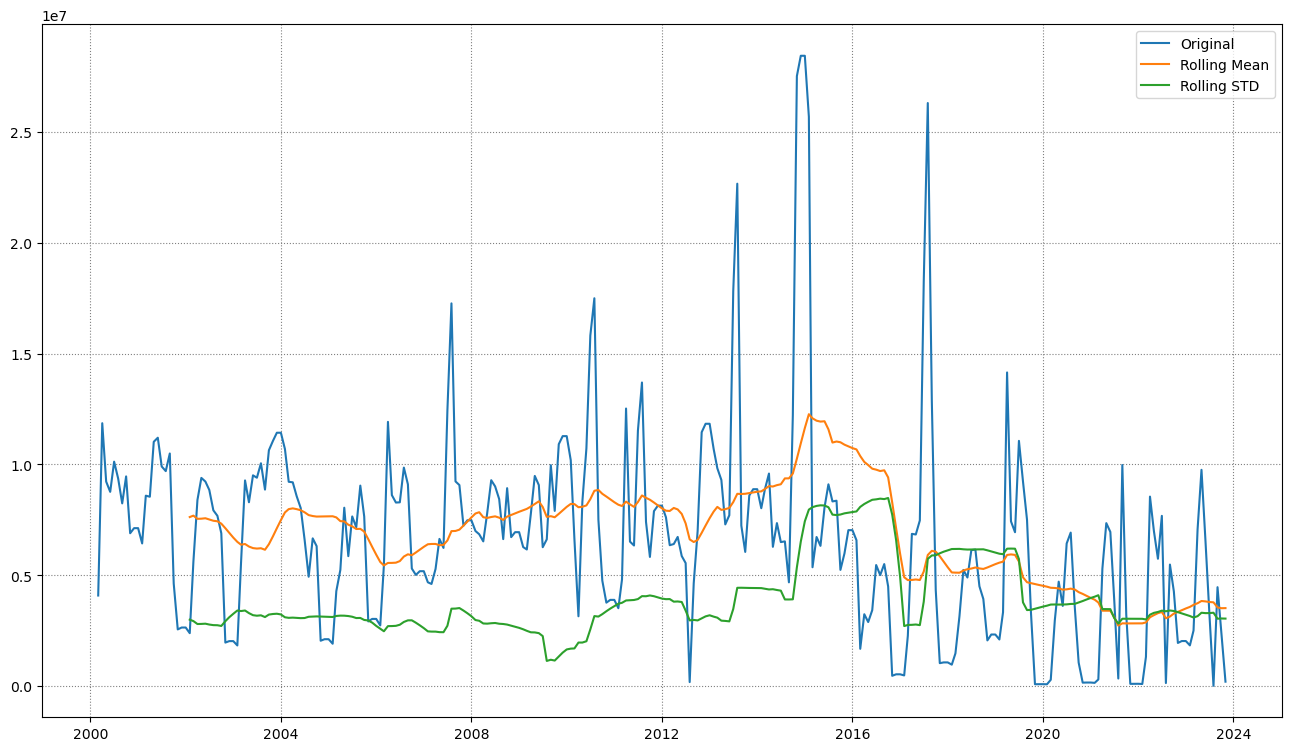

In [95]:
# Plot the rolling mean and standard deviation for a 24-month window 
plot_rolling_mean_and_std(monthly_data['all_motor_vehicles'], window=24)

In [61]:
monthly_data["all_motor_vehicles"].head()

timestamp
2000-03-01     4079983.0
2000-04-01    11856901.0
2000-05-01     9222997.0
2000-06-01     8759275.0
2000-07-01    10122191.0
Name: all_motor_vehicles, dtype: float64

### Seasonalilty and Trends

In [ ]:
from statsmodels.graphics.tsaplots import month_plot

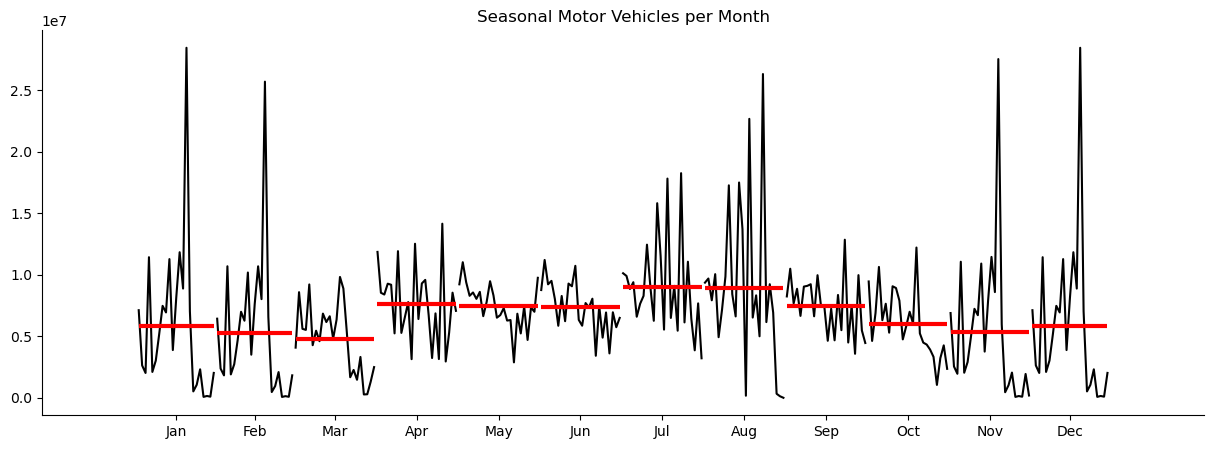

In [96]:
plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(monthly_data["all_motor_vehicles"], ax=plt.gca())
plt.title("Seasonal Motor Vehicles per Month")
sns.despine()
plt.show()

### Dealing with Non-Stationarity

In [63]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series: pd.Series) -> None:
    """
    Perform the Augmented Dickey-Fuller test to check stationarity.
    
    Args:
        series (pd.Series): Time series data
    
    Returns:
        None
    """
    result = adfuller(series.dropna()) 
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

In [64]:
def perform_kpss_test(df: pd.DataFrame) -> None:
    """
    Kwiatkowski-Phillips-Schmidt-Shin test for stationary.
    - The null hypothesis for the test is that the data is stationary.
    - The alternate hypothesis for the test is that the data is not stationary.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data

    Returns: None
    """

    kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags='auto', store=False)
    print('\nKwiatkowski-Phillips-Schmidt-Shin test')
    print('---'*15)
    print('KPSS Statistic: %f' % kpss_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Critical values of KPSS test:')
    for key, value in crit_vals.items():
        print(key, value)

In [65]:
# Perform the ADF test 
perform_adf_test(monthly_data['all_motor_vehicles'])
perform_kpss_test(monthly_data)

ADF Statistic: -7.619120
p-value: 0.000000
Critical Values:
   1%: -3.453670163592738
   5%: -2.8718077069772248
   10%: -2.5722411158835796

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 0.707269
p-value: 0.012885
Number of lags used: 8
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


In [66]:
diff_data = monthly_data['all_motor_vehicles'].diff().dropna() #  calculates the difference between consecutive data points to stabilize the mean of the series

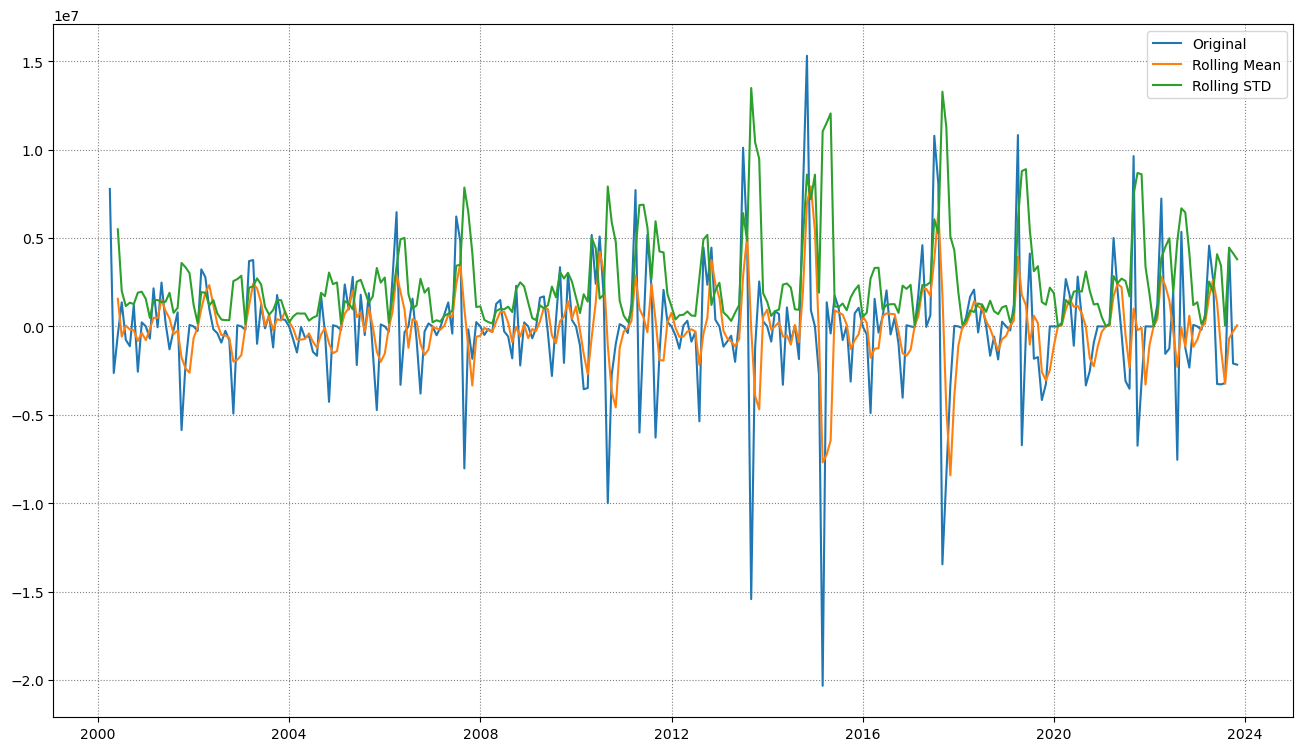

In [97]:
# Plot rolling mean and standard deviation after differencing
plot_rolling_mean_and_std(diff_data, window=3)

In [68]:
# Perform the Augmented Dickey-Fuller test on the differenced data
perform_adf_test(diff_data)
perform_kpss_test(diff_data)

ADF Statistic: -8.733645
p-value: 0.000000
Critical Values:
   1%: -3.45453261164607
   5%: -2.8721859575020017
   10%: -2.572442854861866

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 0.051769
p-value: 0.100000
Number of lags used: 11
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


/var/folders/_z/nz5spzqj2rl11n5lc_k1cwwc0000gn/T/ipykernel_87798/53555551.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags='auto', store=False)


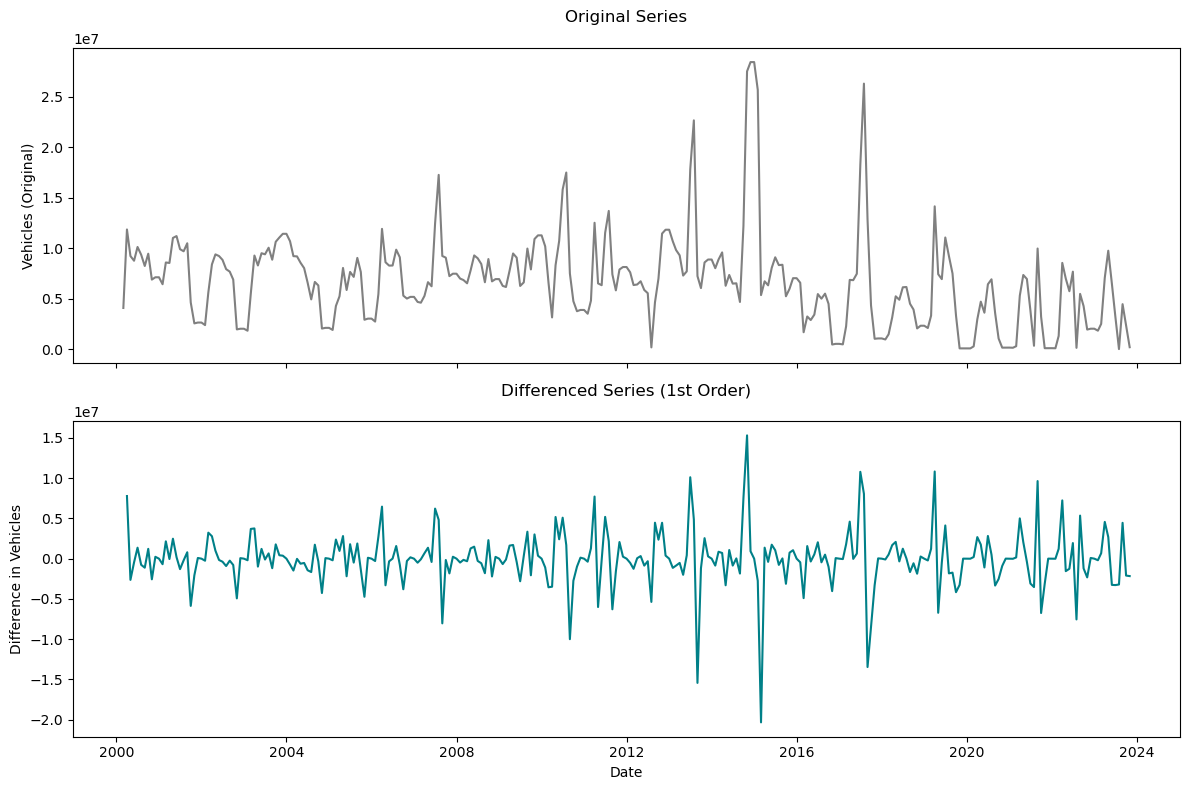

In [69]:
# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

# Plot the original data in the first subplot
ax1.plot(monthly_data['all_motor_vehicles'], color='#808080')
ax1.set_ylabel('Vehicles (Original)')
ax1.set_title('Original Series\n')

# Plot the differenced data in the second subplot
ax2.plot(diff_data, color='#008088')
ax2.set_xlabel('Date')
ax2.set_ylabel('Difference in Vehicles')
ax2.set_title('Differenced Series (1st Order)\n')
plt.tight_layout()
plt.show()

# Autorrelation Analysis

In [70]:
# Plot lag correlations for original series


from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

def lag_plots(series: pd.Series, lags=[1, 12, 24]) -> None:
    """
    This function plots the lag correlation between 
    current y(t) and y(t+1), y(t+12), and y(t+24) lags (default) 
    or any custom lag provided, with customized titles.
    
    Args:
        series (pd.Series): The time series data (single column).
        lags (list): List of lag values for which to create lag plots.
    
    Returns:
        None
    """
    
    # Custom titles for the lags
    titles = ["Correlation with next month", "Correlation with next year", "Correlation with next 2 years"]

    # Number of subplots based on the number of lags
    num_lags = len(lags)
    fig, axes = plt.subplots(1, num_lags, figsize=(16, 9), facecolor='w')
    
    # Loop over the lags to create lag plots for each specified lag
    for i, lag in enumerate(lags):
        lag_plot(series, lag=lag, ax=axes[i], c='#187bcd' if i % 2 == 0 else 'grey')
        
        # Set custom title based on the index of the lag
        axes[i].set_title(titles[i], fontsize=15, pad=10, color='white', backgroundcolor='purple')
        
        # Set x and y axis labels
        axes[i].set_xlabel("y(t)")
        axes[i].set_ylabel(f"y(t+{lag})")
        axes[i].grid(linestyle=":", color='grey')

    plt.tight_layout()
    plt.show()



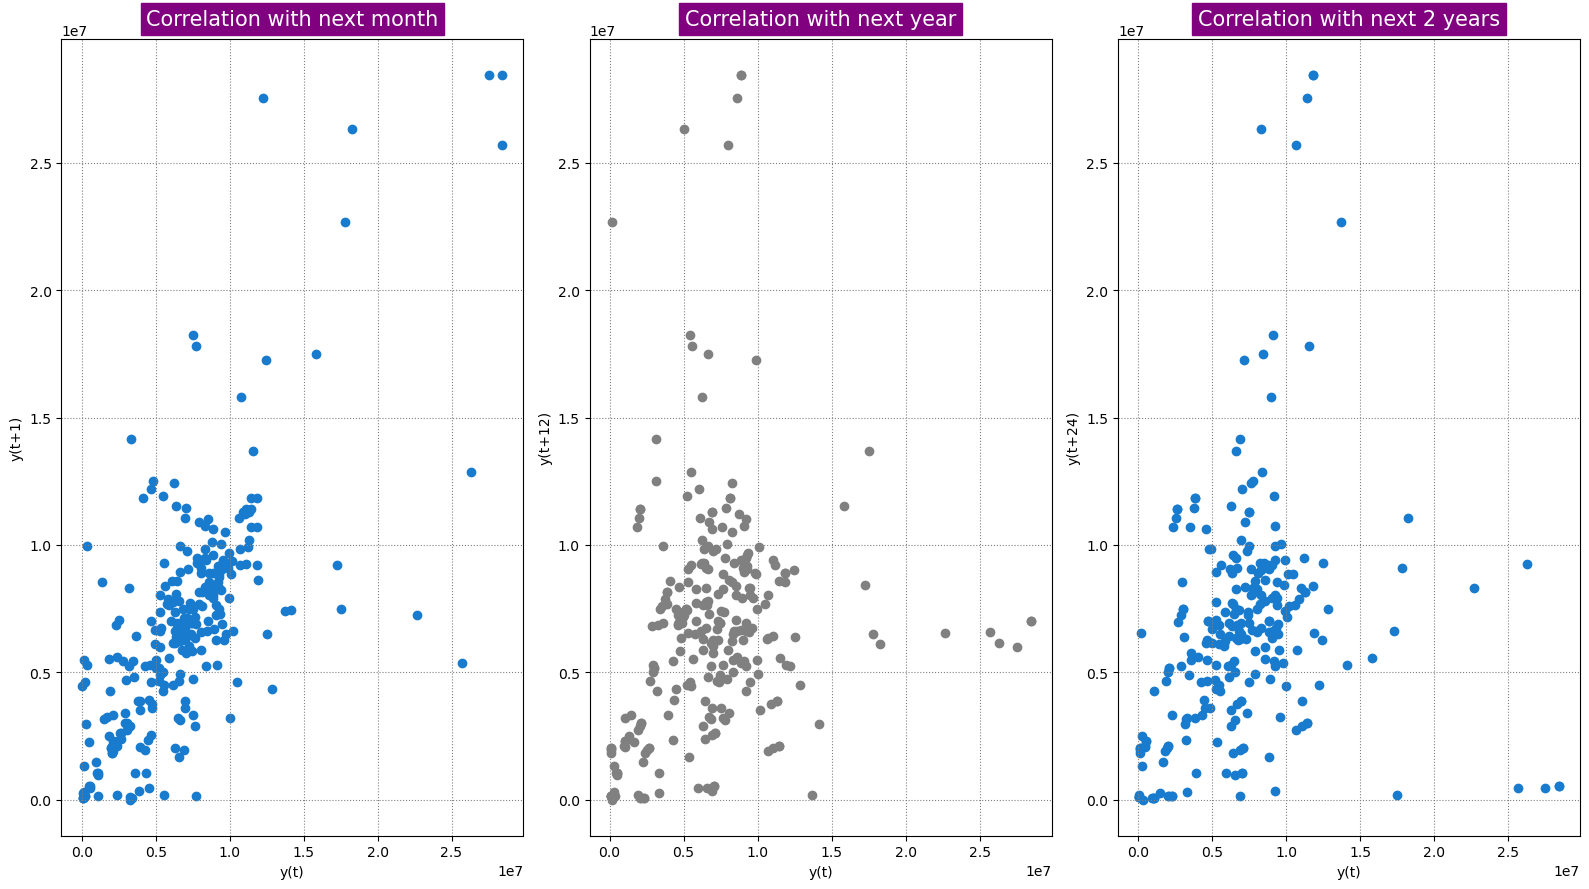

In [71]:
# Plot lag correlations for original series
lag_plots(monthly_data['all_motor_vehicles'], lags=[1, 12, 24])  

### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

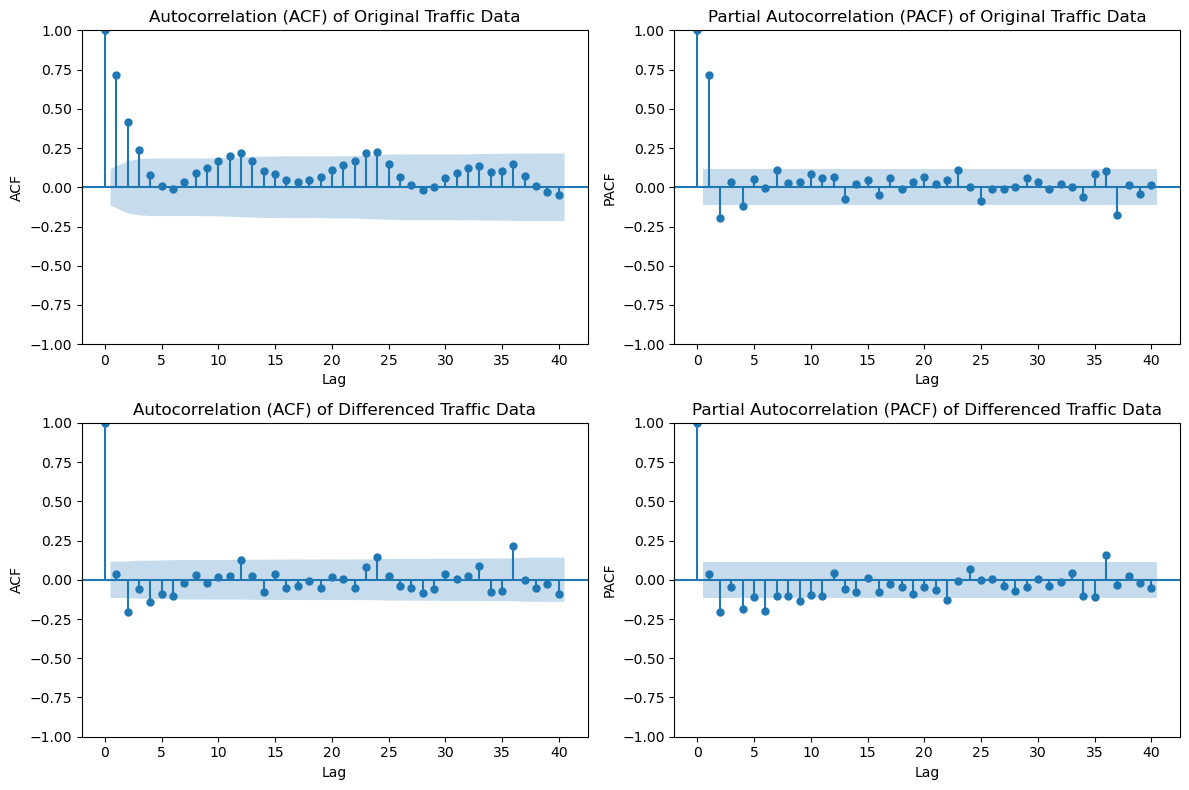

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Apply first-order differencing to the data
diff_data = monthly_data['all_motor_vehicles'].diff().dropna()

# Create subplots for ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 8))

# Plot the ACF for the original data
plot_acf(monthly_data['all_motor_vehicles'].dropna(), lags=40, ax=ax1[0])
ax1[0].set_title('Autocorrelation (ACF) of Original Traffic Data', fontsize=12)
ax1[0].set_xlabel('Lag', fontsize=10)
ax1[0].set_ylabel('ACF', fontsize=10)

# Plot the PACF for the original data
plot_pacf(monthly_data['all_motor_vehicles'].dropna(), lags=40, ax=ax1[1])
ax1[1].set_title('Partial Autocorrelation (PACF) of Original Traffic Data', fontsize=12)
ax1[1].set_xlabel('Lag', fontsize=10)
ax1[1].set_ylabel('PACF', fontsize=10)

# Plot the ACF for the differenced data
plot_acf(diff_data, lags=40, ax=ax2[0])
ax2[0].set_title('Autocorrelation (ACF) of Differenced Traffic Data', fontsize=12)
ax2[0].set_xlabel('Lag', fontsize=10)
ax2[0].set_ylabel('ACF', fontsize=10)

# Plot the PACF for the differenced data
plot_pacf(diff_data, lags=40, ax=ax2[1])
ax2[1].set_title('Partial Autocorrelation (PACF) of Differenced Traffic Data', fontsize=12)
ax2[1].set_xlabel('Lag', fontsize=10)
ax2[1].set_ylabel('PACF', fontsize=10)

# Display the plots
plt.tight_layout()
plt.show()


# Decomposition

In [73]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_series(series: pd.Series, period: int, title: str) -> None:
    """
    This function decomposes the time series into trend, seasonality, and residuals.
    
    Args:
        series (pd.Series): The time series data to decompose.
        period (int): The number of observations per cycle (e.g., 12 for monthly data).
        title (str): Title for the plot.
    
    Returns:
        None
    """
    # Decomposition
    decomposition = seasonal_decompose(series, model='additive', period=period)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 10), facecolor='w')

    ax1.plot(series, label='Original', color='blue')
    ax1.set_title('Original Series')
    ax1.legend()

    ax2.plot(trend, label='Trend', color='red')
    ax2.set_title('Trend')
    ax2.legend()

    ax3.plot(seasonal, label='Seasonality', color='green')
    ax3.set_title('Seasonality')
    ax3.legend()

    ax4.plot(residual, label='Residuals', color='orange')
    ax4.set_title('Residuals')
    ax4.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

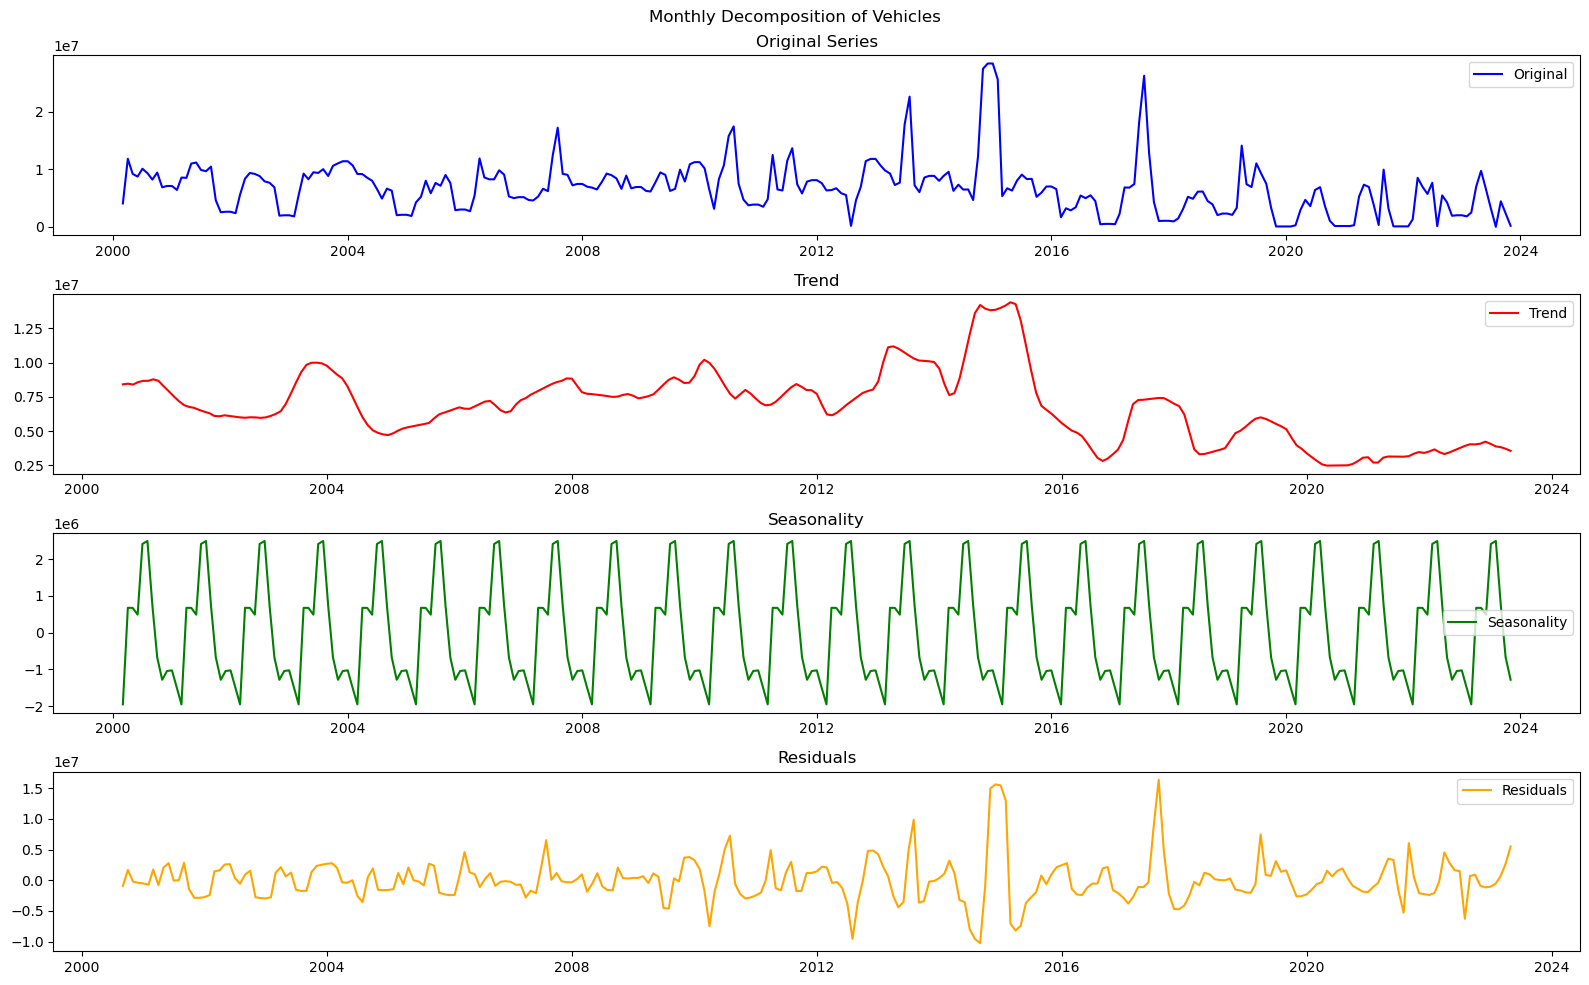

In [74]:
# Decompose the monthly data for 'cars_and_taxis_x'
decompose_series(monthly_data['all_motor_vehicles'], period=12, title='Monthly Decomposition of Vehicles')

In [75]:
monthly_data.shape

(285, 1)

In [77]:
monthly_data.head()

,all_motor_vehicles
timestamp,
2000-03-01,4079983.0
2000-04-01,11856901.0
2000-05-01,9222997.0
2000-06-01,8759275.0
2000-07-01,10122191.0


In [78]:
monthly_data.to_csv("../data/monthly_data.csv")